## Домашнее задание : "Обучение с подкреплением"

ФИО: Бетев Иван

In [2]:
from IPython.display import clear_output, Video

In [2]:
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit2/requirements-unit2.txt
clear_output()

In [3]:
%%capture
!sudo apt-get update
!apt install python-opengl ffmpeg xvfb
!pip3 install pyvirtualdisplay

In [4]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [5]:
import numpy as np
import random
import imageio
import os
import tqdm

import pickle5 as pickle
from tqdm.notebook import tqdm

In [6]:
import gymnasium as gym

# Задание 1

Обучите алгоритм Q-learning для сред FrozenLake-v1 и Blackjack-v1, в частности подберите оптимальную alpha. (1 балл)

In [7]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

def greedy_policy(Qtable, state):
    # Exploitation: take the action with the highest state, action value
    action = np.argmax(Qtable[state][:])
    
    return action

def epsilon_greedy_policy(Qtable, state, epsilon):
    # Randomly generate a number between 0 and 1
    random_num = random.random()
    # if random_num > greater than epsilon --> exploitation
    if random_num > epsilon:
      # Take the action with the highest value given a state
      # np.argmax can be useful here
      action = greedy_policy(Qtable, state)
    # else --> exploration
    else:
      action = env.action_space.sample()# Take a random action
    
    return action

In [8]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable, learning_rate, gamma):
    for episode in tqdm(range(n_training_episodes)):
        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        # Reset the environment
        state, info = env.reset()
        step = 0
        terminated = False
        truncated = False

        # repeat
        for step in range(max_steps):
            # Choose the action At using epsilon greedy policy
            action = epsilon_greedy_policy(Qtable, state, epsilon)

            # Take action At and observe Rt+1 and St+1
            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, terminated, truncated, info = env.step(action)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])   

            # If terminated or truncated finish the episode
            if terminated or truncated:
                break
            
            # Our next state is the new state
            state = new_state
    return Qtable

In [9]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    """
    Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
    :param env: The evaluation environment
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param Q: The Q-table
    :param seed: The evaluation seed array (for taxi-v3)
    """
    episode_rewards = []
    for episode in tqdm(range(n_eval_episodes)):
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            state, info = env.reset()
        step = 0
        truncated = False
        terminated = False
        total_rewards_ep = 0
        
        for step in range(max_steps):
            # Take the action (index) that have the maximum expected future reward given that state
            action = greedy_policy(Q, state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward
              
            if terminated or truncated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [10]:
def record_video(env, Qtable, out_directory, fps=1):
    """
    Generate a replay video of the agent
    :param env
    :param Qtable: Qtable of our agent
    :param out_directory
    :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
    """
    images = []  
    terminated = False
    truncated = False
    state, info = env.reset(seed=random.randint(0,500))
    img = env.render()
    images.append(img)
    while not terminated or truncated:
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(Qtable[state][:])
        state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
        img = env.render()
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

## FrozenLake-v1

In [11]:
env = gym.make("FrozenLake-v1", render_mode="rgb_array")

In [12]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

Qtable_lake = initialize_q_table(state_space, action_space)
print(Qtable_lake)
print("Q-table shape: ", Qtable_lake .shape)

There are  16  possible states
There are  4  possible actions
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-table shape:  (16, 4)


In [26]:
eval_seed = [16,54,165,177,191,191,120,80,149,178,48,38,6,125,174,73,50,172,100,148,146,6,25,40,68,148,49,167,9,97,164,176,61,7,54,55,
 161,131,184,51,170,12,120,113,95,126,51,98,36,135,54,82,45,95,89,59,95,124,9,113,58,85,51,134,121,169,105,21,30,11,50,65,12,43,82,145,152,97,106,55,31,85,38,
 112,102,168,123,97,21,83,158,26,80,63,5,81,32,11,28,148]

model = {
    "env_id": 'FrozenLake-v1',
    "max_steps": 99,
    "n_training_episodes": 25000,
    "n_eval_episodes": 100,
    "eval_seed": eval_seed,

    "learning_rate": np.linspace(0.5, 1, 5),
    "gamma": 0.95,

    "max_epsilon": 1.,
    "min_epsilon": 0.05,
    "decay_rate": 0.005,

    "qtable": Qtable_lake
}

Выбирем лучший lr

In [27]:
for lr in model['learning_rate']:
    env.reset() # ...
    Qtable_lake = train(model['n_training_episodes'], model['min_epsilon'], model['max_epsilon'],
                        model['decay_rate'], env, model['max_steps'], model['qtable'].copy(), learning_rate=lr, gamma=model['gamma'])
    mean, std = evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], Qtable_lake, model["eval_seed"])
    print(f'lr={lr}\tmean: {mean}\tstd: {std}')

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.5	mean: 0.55	std: 0.49749371855331


  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.625	mean: 0.15	std: 0.3570714214271425


  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.75	mean: 0.74	std: 0.4386342439892262


  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.875	mean: 0.6	std: 0.48989794855663565


  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=1.0	mean: 0.0	std: 0.0


In [24]:
env.reset() 
train(model['n_training_episodes'] + 5000, model['min_epsilon'], model['max_epsilon'],
                        model['decay_rate'], env, model['max_steps'], model['qtable'], learning_rate=0.7, gamma=model['gamma'])

  0%|          | 0/30000 [00:00<?, ?it/s]

array([[2.78629819e-01, 1.68644262e-01, 2.67206416e-01, 1.61247839e-01],
       [2.14499144e-02, 8.30402179e-03, 1.68898884e-03, 2.08692000e-01],
       [1.81959224e-02, 1.83557496e-02, 2.37049310e-02, 8.76718111e-02],
       [2.18842028e-02, 3.28871923e-02, 2.39954804e-04, 4.55613865e-02],
       [3.33898203e-01, 7.34779467e-02, 1.18138820e-01, 1.36550557e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.11674989e-03, 2.70445728e-03, 1.17817572e-01, 4.67353606e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.56228386e-02, 2.99912718e-01, 1.50987992e-01, 3.92244937e-01],
       [3.70470636e-02, 6.50497272e-01, 6.84199696e-04, 1.48206370e-02],
       [8.73038442e-01, 6.19817901e-02, 1.19427964e-02, 1.99599710e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.98284725e-02, 5.74481881e-02, 8.28801899e

In [25]:
env.reset()
record_video(env, model["qtable"], "frozen_lake.mp4", 2)
Video("frozen_lake.mp4", embed=True)

## Blackjack-v1

In [28]:
env = gym.make("Blackjack-v1", render_mode="rgb_array")

In [29]:
state_space = [i.n for i in env.observation_space]
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

Qtable_blackjack = np.zeros((*state_space, action_space))
#print(Qtable_blackjack)
print("Q-table shape: ", Qtable_blackjack.shape)

There are  [32, 11, 2]  possible states
There are  2  possible actions
Q-table shape:  (32, 11, 2, 2)


ЗДесь же у нас матрица состоянии 3х-мерная => Q-table 4х-мерная

In [33]:
eval_seed = [16,54,165,177,191,191,120,80,149,178,48,38,6,125,174,73,50,172,100,148,146,6,25,40,68,148,49,167,9,97,164,176,61,7,54,55,
 161,131,184,51,170,12,120,113,95,126,51,98,36,135,54,82,45,95,89,59,95,124,9,113,58,85,51,134,121,169,105,21,30,11,50,65,12,43,82,145,152,97,106,55,31,85,38,
 112,102,168,123,97,21,83,158,26,80,63,5,81,32,11,28,148]

model = {
    "env_id": 'Blackjack-v1',
    "max_steps": 500,
    "n_training_episodes": 200000,
    "n_eval_episodes": 100,
    "eval_seed": eval_seed,

    "learning_rate": np.linspace(0.01, 0.5, 10),
    "gamma": 0.95,

    "max_epsilon": 1.0,
    "min_epsilon": 0.05,
    "decay_rate": 1. / (100000 / 2),

    "qtable": Qtable_blackjack
}

In [34]:
for lr in model['learning_rate']:
    env.reset() # ...
    Qtable_lake = train(model['n_training_episodes'], model['min_epsilon'], model['max_epsilon'],
                        model['decay_rate'], env, model['max_steps'], model['qtable'].copy(), learning_rate=lr, gamma=model['gamma'])
    mean, std = evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], Qtable_lake, model["eval_seed"])
    print(f'lr={np.round(lr, 3)}\tmean: {mean}\tstd: {std}')

  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.01	mean: -0.14	std: 0.9593747964169165


  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.064	mean: -0.16	std: 0.9562426470305536


  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.119	mean: -0.17	std: 0.9492628719169417


  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.173	mean: -0.11	std: 0.9475758544834288


  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.228	mean: -0.08	std: 0.9453041838477179


  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.282	mean: -0.11	std: 0.9475758544834288


  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.337	mean: -0.19	std: 0.9348261870529729


  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.391	mean: -0.08	std: 0.9558242516278816


  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.446	mean: -0.1	std: 0.9539392014169458


  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lr=0.5	mean: -0.1	std: 0.9433981132056605


меньше всего быдло проигрышей с lr=0.228

In [35]:
env.reset() # ...
train(model['n_training_episodes'], model['min_epsilon'], model['max_epsilon'],
                        model['decay_rate'], env, model['max_steps'], model['qtable'], learning_rate=0.228, gamma=model['gamma']);

  0%|          | 0/200000 [00:00<?, ?it/s]

In [42]:
record_video(env, model["qtable"], "blackjack.mp4", 1)
Video("blackjack.mp4", embed=True)

# Задание 2

Обучите алгоритм Policy Gradients (или Actor Critic) для среды https://www.gymlibrary.dev/environments/atari/breakout/ . Продемонстрируйте, что для обученного агента растет время игры. (3 балла)

**Блин жесть я конечно замучился с этой средой, пришлось идти на ухищирения...**


In [43]:
!pip install gym[atari]
!pip install gym[accept-rom-license]
!pip install ale-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 21.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=b815415d81d5f87144cbef67c80ee71079ec2eaddcd2034a045dbc02f8ea2845
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import matplotlib.pyplot as plt

In [45]:
import gym

env = gym.make("ALE/Breakout-v5")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


**Имеем 4 действия и rgb поле размером 210х160**

0 - стоять

1 - огонь

2 - право

3 - лево

In [9]:
print(env.action_space, env.observation_space)

Discrete(4) Box(0, 255, (210, 160, 3), uint8)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Будем реализовывать алгоритм Gradients Policy

![](https://habrastorage.org/webt/46/jp/or/46jporp-h9pj-bujcmytwhnfmze.png)

Где актер будет выдавать вероятности действии (оставлю ему на выбор только 2: шаг налево или вправо)

Сначала мы будем копить статистику действии, то есть имеем состояние, действие, которое решил сделать актер, и награду, полученную за это действие.

Так как большая часть действии имеет награду 0, поступим так: как только получаем 1 награду, то всем действиям, которые привели актера к этому, присваиваем тоже награду 1. В случае награды -1 аналогично

После, накапившуюся статистику, то есть сформированный датасет, подаем на обучение актера 

В лоссе логарифмируем вероятности действии и умножаем их на награду, полученную за них. Это делать законно, так как $r_j$ служит как бы весом для градиентов при обратном распространении ошибки, когда мы обучаем актера

**Так выглядит срендеренное поле**

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


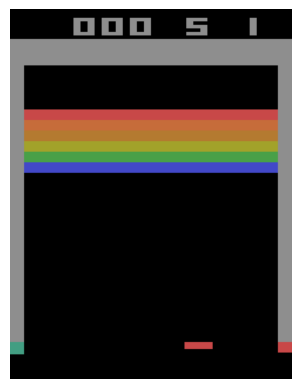

In [47]:
env.reset()
plt.axis('off')
plt.imshow(env.render(mode='rgb_array'));

**Актеру неинтересна информация об оставшихся жизнях и текущий скор, поэтому будем брать такой срез для него**

(175, 160, 3)


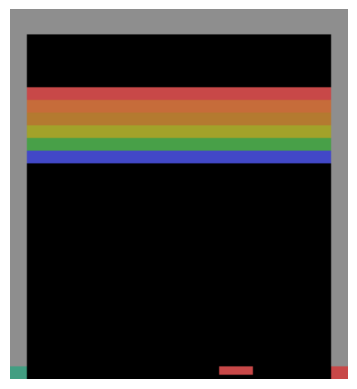

In [48]:
env.reset()
img = env.render(mode='rgb_array')[20:195]
plt.axis('off')
print(img.shape)
plt.imshow(img);

Господи, я так долго мучился и так и не понял, за что дается награда, так как я все время (даже за то что отбил мяч и выбил квадратик) получал награду 0. Поэтому решил считать ее по своему: берем срез поля по квадратикам и все время считаем его среднее, если квадратик выбит => образуется черное пространсво, то есть среднее уменьшится. В таком случае получаем положительную награду

А случай проигрыша возникает, когда мы пропускаем мяч. Это можно детектировать счетчиком жизней, который содержится в info['lives'] 

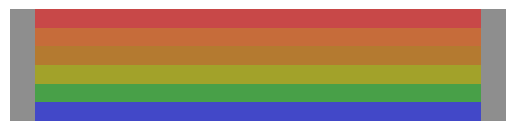

In [49]:
env.reset()
img = env.render(mode='rgb_array')
plt.axis('off')
plt.imshow(img[57:93]);

In [13]:
import torch

Здесь имеем буффер для накопа статы aka датасет

In [14]:
from collections import namedtuple, deque

class ExpirienceReplayBuffer(torch.utils.data.Dataset):

    def __init__(self, memory_size=500):
        super(ExpirienceReplayBuffer, self).__init__()
        self.memory_size = memory_size
        self.Buffer = namedtuple('Buffer', field_names=['state', 'action', 'reward'])
        self.replay_memory = deque(maxlen=memory_size)
        self.len_ = 0
    
    def __len__(self):
        return self.len_
    
    def __getitem__(self, idx):
        item = self.replay_memory[idx]        
        return item.state, item.action, item.reward


    def append(self, state, action, reward):
        self.replay_memory.append(self.Buffer(state, action, reward))
        self.len_ += 1
    
    def append_batch(self, state_batch, action_batch, reward_batch):
        for i in range(len(state_batch)):
            self.append(state_batch[i], action_batch[i], reward_batch[i])

    def clear(self):
        self.len_ = 0
        self.replay_memory.clear()
        

In [15]:
from tqdm.notebook import tqdm

Архитектура актера представляет себя вполне стандартную сверточную NN

In [16]:
import torch.nn as nn 

class Actor(torch.nn.Module):
    def __init__(self):
        super(Actor, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()

        self.fc = nn.Sequential(
            nn.Linear(3200, 512),
            nn.Dropout(0.25),
            nn.Linear(512, 256),
            nn.Linear(256, 2),
            nn.Softmax()
        )
        
    def forward(self, x):
      x = self.relu(self.max_pool(self.conv1(x)))
      x = self.relu(self.max_pool(self.conv2(x)))
      x = self.relu(self.max_pool(self.conv3(x)))
      x = self.relu(self.max_pool(self.conv4(x)))

      x = x.view(x.shape[0], -1)

      #print(x.shape)

      x = self.fc(x)
      return x


А тут самое интересное: функция обучения актера в эпизод игры, то есть играем, пока не кончились жизни, а потом по памяти обучаемся

In [17]:
def train_actor_episode(actor, optim, env, max_batch_len=64, num_epoch=5, device='cuda'):
    buffer = ExpirienceReplayBuffer() # буффер для статы 
    terminated = False # индикатор конца игры
    cur_lives_count = 5 # счетчик жизней для детектирования провала
    states_batch = [] # сборщик батча для состоянии
    actions_batch = [] # сборщик батча для действии

    actor.eval()
    with torch.no_grad():
      env.reset() # перезапустили среду
      env.step(1) # начинаем игру, то есть бросаем мяч
      state = env.render(mode='rgb_array') # рендерим состояние
      cur_score = state[57:93].mean() # считаем текущий скор
      state = state[20:195] # обрезаем, чтобы актер схавал
      while not terminated:
          torch.cuda.empty_cache()

          state = torch.FloatTensor(state).permute(2, 0, 1).to(device)
          # нормализуем, чтобы были значения от 0 до 1
          state = (state - torch.min(state)) / (torch.max(state) - torch.min(state))
          probs = actor(state.unsqueeze(0)) # вероятности действии
          action = torch.argmax(probs, axis=1)[0].item() # выбираем наиболее вероятное
          
          states_batch.append(state.cpu()) # закинули тензор в батч
          actions_batch.append(action) # действие в батч

          # делаем шаг + сдвиг действия на 2, так как их номера 2, 3
          state, reward, terminated, info = env.step(action + 2)
          score = state[57:93].mean() # посчитали скор
          state = state[20:195] # обрезали карту

          if info['lives'] < cur_lives_count: # если мы ошиблись, то есть просрали жизнь
              env.step(1) # нужно запульнуть снова мяч
              cur_lives_count -= 1 # обновили состояние жизней
              # в буффер кидаем батчи состоянии и действии + всем им присуждаем отрицательную награду
              buffer.append_batch(states_batch, actions_batch, [-1.] * len(states_batch))
              # чистим батчи
              states_batch.clear()
              actions_batch.clear()
          elif score < cur_score: # если скор уменьшился, то есть выбили квадратик
              cur_score = score # обновили скор
              # в буффер кидаем батчи состоянии и действии + теперь им присуждаем положительную награду
              buffer.append_batch(states_batch, actions_batch, [1.] * len(states_batch))
              states_batch.clear()
              actions_batch.clear()

    # переходим к тренировке актера
    actor.train()
    losses = []
    dataloader = torch.utils.data.DataLoader(buffer, batch_size=max_batch_len)
    for epoch in range(num_epoch):
        losses_epoch = []
        for states, actions, rewards in dataloader:

            # переносим на cuda
            image_tensor = states.to(device)
            score_tensor = rewards.to(device)
            action_tensor = actions.long().to(device)

            optim.zero_grad()

            prob = torch.log(actor(image_tensor)) # посчитали логарифмы вероятностей
            # умножаем нужные действия, на полученную награду
            selected_probs = score_tensor * prob[np.arange(len(action_tensor)), action_tensor]
            loss = -selected_probs.mean() # считаем лосс
            losses_epoch.append(loss.item())

            loss.backward()
            optim.step()
        losses.append(np.mean(losses_epoch))

    buffer.clear()
    actor.eval()
    return actor, losses

In [26]:
# функция для просмотра игры, после i-ой итерации обучения
def make_video_episode(actor, env, num_episode):
    images = []
    actor.eval()
    cur_lives = 5
    terminated = False
    with torch.no_grad():
      env.reset()
      env.step(1) # start game = fire
      state = env.render(mode='rgb_array')
      images.append(state)
      state = state[20:195]
      while not terminated:
          state = torch.FloatTensor(state).permute(2, 0, 1).to(device)
          state = (state - torch.min(state)) / (torch.max(state) - torch.min(state))
          probs = actor(state.unsqueeze(0))
          action = torch.argmax(probs, axis=1)[0].item()
          
          state, reward, terminated, info = env.step(action + 2)
          images.append(state)
          state = state[20:195]

          if info['lives'] < cur_lives:
              cur_lives -= 1
              env.step(1) # fire

    imageio.mimsave(f'{num_episode}.mp4', [np.array(img) for i, img in enumerate(images)], fps=3)



device = 'cuda'
actor = Actor().to(device)
optim = torch.optim.Adam(actor.parameters(), lr=3e-4)

for i in range(30):
    actor, losses = train_actor_episode(actor, optim, env, num_epoch=1)
    if (i+1) % 5 == 0:
        print(f'Iteration {i + 1} done')
    if (i+1) % 10 == 0:
        make_video_episode(actor, env, i + 1)

Iteration 5 done
Iteration 10 done


Iteration 15 done
Iteration 20 done


Iteration 25 done
Iteration 30 done


In [27]:
Video("10.mp4", embed=True)

In [28]:
Video("20.mp4", embed=True)

**ОНО РАБОТАЕТ МАТЬ ЕГО!!!**

In [3]:
Video("30.mp4", embed=True)